In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table

In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [4]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [5]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path
from kndetect.features import extract_features_all_lightcurves
from kndetect.training import append_y_true_col

In [6]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [7]:
use_already_trained_features = False
use_already_trained_models = False
mimic_alerts = True
save_data = True

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"

In [8]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"),index_col=0)

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

100%|██████████| 22280/22280 [06:42<00:00, 55.42it/s]


In [9]:
train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.727304,-0.098875,0.355660,1.610522,373.748047,1757,57661.2481,150,150: KN GW170817,True
1,0.774441,0.286351,0.143057,0.310712,427.853790,1.081344,-0.078730,-0.098406,2.304110,788.683228,6415,57454.4909,141,141: 91BG,False
2,1.031763,-0.063429,0.317005,0.971762,270.629425,0.876449,0.080352,0.104214,0.825639,401.693390,7707,57487.1585,103,103: Core collapse Type Ibc,False
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.665152,0.140315,0.398468,0.896813,239.701599,8267,57668.3579,151,151: KN Karsen 2017,True
4,1.028029,-0.020704,0.038843,0.993747,263.286224,1.163227,-0.289741,0.228756,0.581479,291.099426,12578,57533.3567,102,102: MOSFIT-Ibc,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22275,1.125437,-0.000773,0.163598,1.729413,888.318420,1.146134,-0.144064,0.514439,2.025476,666.974243,137062467,57506.4101,112,112: Core collapse Type II,False
22276,0.978098,-0.118905,-0.022548,1.571079,1141.677979,1.038589,-0.084343,0.017370,1.344228,1213.934937,137071784,57672.5321,170,170: AGN,False
22277,1.106489,-0.117177,0.207583,1.182281,295.870941,1.016971,-0.049108,0.042611,0.732499,408.148193,137071978,57611.3287,143,143: Iax,False
22278,0.520047,0.028291,0.387530,1.772421,525.301697,0.729638,0.288043,0.358201,1.403918,445.314880,137079473,57496.2954,151,151: KN Karsen 2017,True


# Now Train the classifier

In [10]:
from kndetect.training import train_classifier

In [11]:
if not use_already_trained_models:
    clf, features_df = train_classifier(train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    from kndetect.predict import load_classifier
    clf = load_classifier(sub_directory + ".pkl")

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [12]:
# Generate Test features and Predict probabilities

In [13]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [14]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

100%|██████████| 21288/21288 [06:16<00:00, 56.51it/s]


In [15]:
from kndetect.predict import load_classifier, predict_kn_score

In [16]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)

In [17]:
test_features_df['y_pred_score'] = probabilities.T[1]

In [18]:
filtered=test_features_df[filtered_indices]

In [19]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_pred_score"]>0.5

In [20]:
y_true_train = features_df["y_true"]
y_pred_train = features_df["y_pred"]

print("train statistics:")
print("\ntotal number of events: " + str(len(y_true_train)))
print("total number of KN: " + str(np.sum(y_true_train)))
print("total number of non KN: " + str(np.sum(~y_true_train))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true_train&y_pred_train)))
print("False Positive : {fp}".format(fp = np.sum(~y_true_train&y_pred_train)))
print("True negative : {tn}".format(tn = np.sum(~y_true_train&~y_pred_train)))
print("False negative : {fn}".format(fn = np.sum(y_true_train&~y_pred_train)))


train statistics:

total number of events: 22280
total number of KN: 3280
total number of non KN: 19000

True Positive : 2405
False Positive : 358
True negative : 18642
False negative : 875


In [21]:
features_df[features_df["type"]==151]

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred,y_score
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.665152,0.140315,0.398468,0.896813,239.701599,8267,57668.3579,151,151: KN Karsen 2017,True,False,0.319155
10,0.706510,0.065997,0.348946,4.127720,1721.492798,0.633226,0.109101,0.277846,4.835148,1562.443726,22525,57490.2165,151,151: KN Karsen 2017,True,True,0.833090
33,0.000000,0.000000,0.000000,0.000000,0.000000,0.649960,-0.064836,0.393919,2.156433,787.250732,116775,57690.1270,151,151: KN Karsen 2017,True,True,0.766842
51,0.773916,-0.097459,0.293853,2.962483,408.353363,0.000000,0.000000,0.000000,0.000000,0.000000,207459,57436.5012,151,151: KN Karsen 2017,True,True,0.743453
58,0.540562,0.359225,0.022155,1.883524,926.869141,0.603690,0.289487,0.019800,1.361489,1061.635254,231140,57650.2938,151,151: KN Karsen 2017,True,True,0.725837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22253,0.788062,0.088312,0.250007,1.180534,386.102020,0.999753,0.074311,0.013785,1.009923,457.313232,136959425,57629.3402,151,151: KN Karsen 2017,True,False,0.416128
22255,0.865400,0.120031,0.145721,2.322712,1708.722778,0.825873,0.156394,0.147347,2.216666,1886.712769,136970486,57653.4004,151,151: KN Karsen 2017,True,True,0.588870
22258,0.968095,0.050990,0.052179,1.007638,471.565826,0.672429,0.092215,-0.501572,0.973459,382.670197,136976627,57653.2097,151,151: KN Karsen 2017,True,False,0.475181
22273,0.579835,0.238880,0.001025,7.209192,4120.973633,1.010048,0.062081,-0.002372,1.646331,5347.779297,137057324,57633.3774,151,151: KN Karsen 2017,True,True,0.793907


In [22]:
print("test statistics:")
print("\ntotal number of events: " + str(len(y_true)))
print("total number of KN: " + str(np.sum(y_true)))
print("total number of non KN: " + str(np.sum(~y_true))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true&y_pred)))
print("False Positive : {fp}".format(fp = np.sum(~y_true&y_pred)))
print("True negative : {tn}".format(tn = np.sum(~y_true&~y_pred)))
print("False negative : {fn}".format(fn = np.sum(y_true&~y_pred)))

test statistics:

total number of events: 14897
total number of KN: 1129
total number of non KN: 13768

True Positive : 702
False Positive : 380
True negative : 13388
False negative : 427


In [23]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

[[0.89870444 0.02550849]
 [0.02866349 0.04712358]]


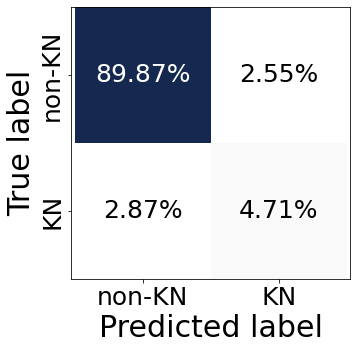

In [24]:
from kndetect.plot_lightcurve import plot_confusion_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plot_confusion_matrix(ax, y_true, y_pred)

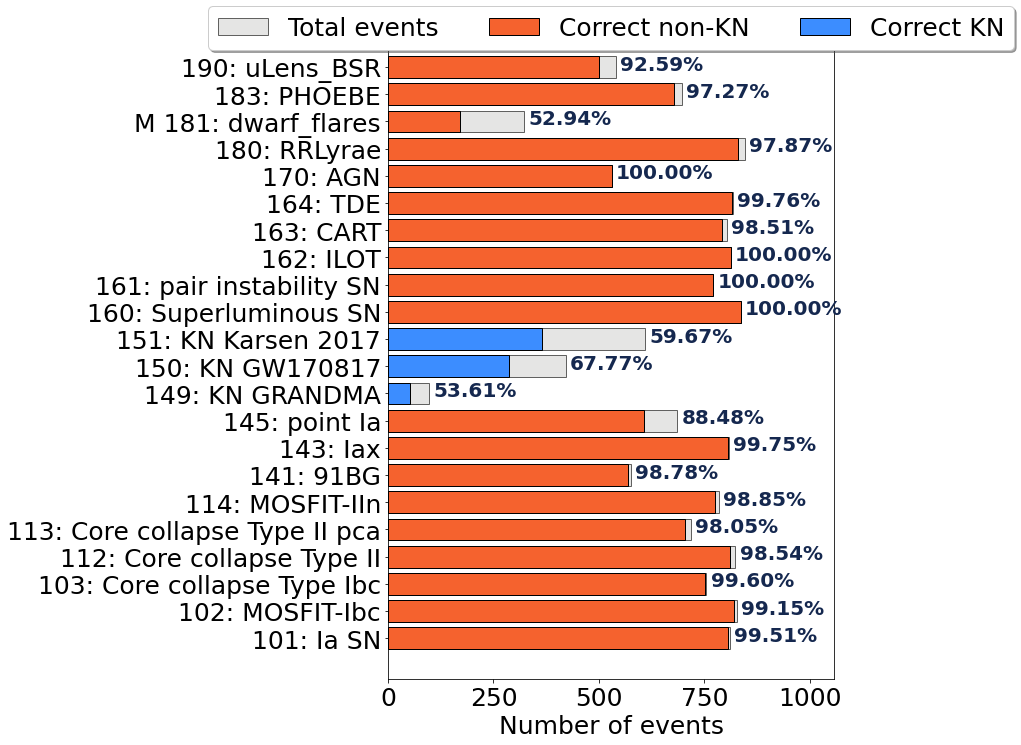

In [25]:
from kndetect.plot_lightcurve import plot_contamination_statistics
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,12))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151])